# Semantic Textual Similarity

Authors: Adrián Tormos Llorente and Ferran Agulló López

In [74]:
# imports
import re
import string
import nltk
import numpy as np
from scipy.stats import pearsonr
from nltk.metrics import jaccard_distance
from nltk.stem import WordNetLemmatizer
from nltk.wsd import lesk
from nltk import pos_tag
import matplotlib.pyplot as plt

# required downloads
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ferran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load data

In [63]:
def load_values_file(path, array):
    with open(path) as f:
        data = f.read()
        splitted_data = re.split('\n+', data) # split raw data by tabs and end of lines
        if splitted_data[-1] == '':
            del splitted_data[-1] # delete last list empty value caused by splitting the last end of line
        for pair in splitted_data:
            sentence1, sentence2 = pair.split('\t')
            array.append((sentence1, sentence2))
    return array

def load_labels_file(path, array):
    with open(path) as f:
        data = f.read()
        splitted_data = re.split('\n+', data) # split raw data by tabs and end of lines
        if splitted_data[-1] == '':
            del splitted_data[-1] # delete last list empty value caused by splitting the last end of line
        for score in splitted_data:
            array.append(float(score))
    return array

We load the train data

In [64]:
train_values = []
train_labels = []
train_path = './input/train'

train_values = load_values_file(train_path + '/STS.input.MSRpar.txt', train_values)
train_values = load_values_file(train_path + '/STS.input.MSRvid.txt', train_values)
train_values = load_values_file(train_path + '/STS.input.SMTeuroparl.txt', train_values)

train_labels = load_labels_file(train_path + '/STS.gs.MSRpar.txt', train_labels)
train_labels = load_labels_file(train_path + '/STS.gs.MSRvid.txt', train_labels)
train_labels = load_labels_file(train_path + '/STS.gs.SMTeuroparl.txt', train_labels)

print('Train values length:', len(train_values), '; Train labels length:', len(train_labels))

Train values length: 2234 ; Train labels length: 2234


We load the test data

In [65]:
test_values = []
test_labels = []
test_path = './input/test-gold'

test_values = load_values_file(test_path + '/STS.input.MSRpar.txt', test_values)
test_values = load_values_file(test_path + '/STS.input.MSRvid.txt', test_values)
test_values = load_values_file(test_path + '/STS.input.SMTeuroparl.txt', test_values)
test_values = load_values_file(test_path + '/STS.input.surprise.OnWN.txt', test_values)
test_values = load_values_file(test_path + '/STS.input.surprise.SMTnews.txt', test_values)

test_labels = load_labels_file(test_path + '/STS.gs.MSRpar.txt', test_labels)
test_labels = load_labels_file(test_path + '/STS.gs.MSRvid.txt', test_labels)
test_labels = load_labels_file(test_path + '/STS.gs.SMTeuroparl.txt', test_labels)
test_labels = load_labels_file(test_path + '/STS.gs.surprise.OnWN.txt', test_labels)
test_labels = load_labels_file(test_path + '/STS.gs.surprise.SMTnews.txt', test_labels)

print('Test values length:', len(test_values), '; Test labels length:', len(test_labels))

Test values length: 3108 ; Test labels length: 3108


## Description of the approach

blablabla

### Preprocessing

Firstly we define some functions to increase the legiility of the following code. We know that doing these steps in different functions is not optimal, because we read multiple times the dataset. However, we think it is not important considering the little amount of data and that this exercise it is just a practice.

In [23]:
# Load the more common punctuation symbols
punctuation_set = set(string.punctuation)
punctuation_set.add('``')
punctuation_set.add('\'\'')
# Load english stop words
sw_set = set(nltk.corpus.stopwords.words('english'))
# Create lemmatizer
wnl = WordNetLemmatizer()

In [43]:
def lower_case(sentence):
    # pre: the sentence in one string
    return sentence.lower()

def word_tokenize(sentence):
    # pre: the sentence in one string
    return nltk.word_tokenize(sentence)

def punctuation_removal(tokens):
    output = []
    for token in tokens:
        if token not in punctuation_set:
            output.append(token)
    return output

def stopwords_removal(tokens):
    output = []
    for token in tokens:
        if token not in sw_set:
            output.append(token)
    return output

def pos_tagging(tokens):
    pairs = pos_tag(tokens)
    tags = [tag for token, tag in pairs]
    return tags

def lemmatization(tokens, tags):
    # post: return the input list of tokens replacing them if possible by their lemmas
    output = []
    for index, token in enumerate(tokens):
        tag = tags[index]
        try:
            output.append(wnl.lemmatize(token, pos=tag[0].lower()))
        except:
            output.append(token)
    return output

def word_sense_disambiguation(tokens, tags):
    # post: return the input list of tokens replacing them if possible by their synsets disambiguated
    output = []
    for index, token in enumerate(tokens):
        tag = tags[index]
        synset = lesk(tokens, token, tag[0].lower())
        if synset is None:
            output.append(token)
        else:
            output.append(synset)
    return output

def run(sentence, steps):
    # pre: the sentence in one string
    tokens = None
    tags = None
    for step in steps:
        if step == 'word_tokenization':
            tokens = word_tokenize(sentence)
        elif step == 'punctuation_removal':
            tokens = punctuation_removal(tokens)
        elif step == 'stopwords_removal':
            tokens = stopwords_removal(tokens)
        elif step == 'pos_tagging':
            tags = pos_tagging(tokens)
        elif step == 'lemmatization':
            tokens = lemmatization(tokens, tags)
        elif step == 'word_sense_disambiguation':
            tokens = word_sense_disambiguation(tokens, tags)
    return tokens, tags
    
def do_pipeline(sentence_pairs, steps):
    output = []
    for pair in sentence_pairs:
        sentence1, sentence2 = pair
        tokens1, tags1 = run(sentence1, steps)
        tokens2, tags2 = run(sentence2, steps)
        if tags1 is not None:
            output.append(((tokens1, tags1), (tokens2, tags2)))
        else:
            output.append((tokens1, tokens2))
    return output

In [46]:
def pretty_print_sentence(original_sentence, processed_sentence, tags):
    print('\nSentence')
    print('Original:', original_sentence)
    if tags:
        print('Tags:', processed_sentence[0])
        print('Tokens:', processed_sentence[1])
    else:
        print('Tokens:', processed_sentence)

We split the sentences by blanks, delete the punctuation symbols, do postagging and lemmatization.

In [50]:
steps = ['word_tokenization', 'punctuation_removal', 'pos_tagging', 'lemmatization']
tags = True
train_output = do_pipeline(train_values, steps)
test_output = do_pipeline(test_values, steps)

We show some sentences:

In [51]:
pretty_print_sentence(train_values[0][0], train_output[0][0], tags)
pretty_print_sentence(train_values[0][1], train_output[0][1], tags)


Sentence
Original: But other sources close to the sale said Vivendi was keeping the door open to further bids and hoped to see bidders interested in individual assets team up.
Tags: ['But', 'other', 'source', 'close', 'to', 'the', 'sale', 'say', 'Vivendi', 'be', 'keep', 'the', 'door', 'open', 'to', 'further', 'bid', 'and', 'hop', 'to', 'see', 'bidder', 'interested', 'in', 'individual', 'asset', 'team', 'up']
Tokens: ['CC', 'JJ', 'NNS', 'RB', 'TO', 'DT', 'NN', 'VBD', 'NNP', 'VBD', 'VBG', 'DT', 'NN', 'JJ', 'TO', 'JJ', 'NNS', 'CC', 'VBD', 'TO', 'VB', 'NNS', 'JJ', 'IN', 'JJ', 'NNS', 'VBP', 'RP']

Sentence
Original: But other sources close to the sale said Vivendi was keeping the door open for further bids in the next day or two.
Tags: ['But', 'other', 'source', 'close', 'to', 'the', 'sale', 'say', 'Vivendi', 'be', 'keep', 'the', 'door', 'open', 'for', 'further', 'bid', 'in', 'the', 'next', 'day', 'or', 'two']
Tokens: ['CC', 'JJ', 'NNS', 'RB', 'TO', 'DT', 'NN', 'VBD', 'NNP', 'VBD', 'VBG', 

### Post processing

do stuff

### Similarity

We compute the similarity with the Jaccard similarity metric for the different pairs of sentences of the two sets.

In [69]:
def compute_jaccard_distance(list1, list2): # it is symmetric
    return jaccard_distance(set(list1),set(list2)) # from nltk

def compute_jaccard_similarity(list1, list2): # it is symmetric
    return 1 - compute_jaccard_distance(list1, list2)

def compute_pair_comparison(pairs, tags):
    output = np.zeros(len(pairs))
    for index, pair in enumerate(pairs):
        if tags:
            tokens1 = pair[0][0]
            tokens2 = pair[1][0]
        else:
            tokens1 = pair[0]
            tokens2 = pair[1]
        output[index] = compute_jaccard_similarity(tokens1, tokens2)
        index += 1
    return output      

In [70]:
train_results = compute_pair_comparison(train_output, tags)
test_results = compute_pair_comparison(test_output, tags)

In [71]:
print('Train results')
print(train_results)
print('\nTest results')
print(test_results)

Train results
[0.53333333 0.38888889 0.31818182 ... 1.         0.55555556 0.375     ]

Test results
[0.31818182 0.28       0.47826087 ... 0.06666667 0.3        0.46153846]


We can see that:
- blabla
- blabla

## Correlation with the gold standard

Now we do the Pearson correlation with the gold standard for the two sets

In [83]:
def show_scatter_plot(labels, results, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.scatter(labels, results)
    ax.set_xlabel('Gold standard')
    ax.set_ylabel('Jaccard similarity')
    ax.set_title(title)
    plt.show()

In [72]:
print('Train results')
print(pearsonr(train_labels, train_results)[0])
print('\nTest results')
print(pearsonr(test_labels, test_results)[0])

Train results
0.4764116359483076

Test results
0.4384096557413677


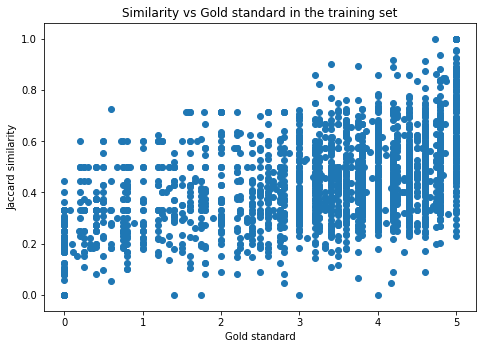

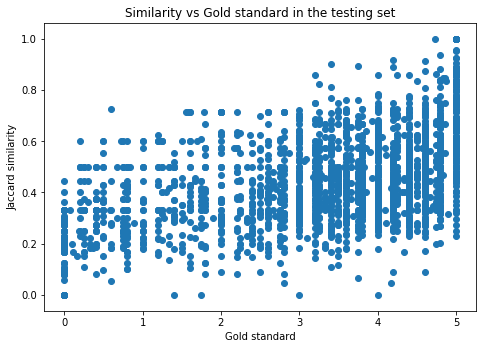

In [84]:
show_scatter_plot(train_labels, train_results, 'Similarity vs Gold standard in the training set')
show_scatter_plot(train_labels, train_results, 'Similarity vs Gold standard in the testing set')

With these results we can say that:
- blabla
- blabla